In [25]:
import pandas as pd
import yfinance as yf
import statsmodels.tsa.stattools as smt
import datetime
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import read_csv
from sklearn.linear_model import LinearRegression
import math

# Вспомогательные функции

In [26]:
# функция для проверки стационарности временного ряда
def is_stationary(timeseries):
    adf_test = adfuller(timeseries)
    p_value = adf_test[1]
    if p_value < 0.05:
        return True
    else:
        return False

In [27]:
# функция для проверки коинтеграции между двумя временными рядами


def engle_granger_test(x, y):
    # оценка регрессии двух временных рядов
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    residuals = model.resid
    
    # проверка стационарности остатков регрессии
    if is_stationary(residuals):
#         print("Тест Энгла-Гранжера: есть коинтеграция")
        return True
    else:
#         print("Тест Энгла-Гранжера: нет коинтеграции")
        return False

In [28]:
#KSS тест
def kss_test(x, y, lin=True):
    """
    Функция для проверки коинтеграции между двумя временными рядами
    с использованием KSS теста.

    Аргументы:
    x - временной ряд 1
    y - временной ряд 2
    lin - логический флаг, определяющий тип теста: True - линейный, False - нелинейный

    Возвращает:
    True, если коинтеграция есть, False в противном случае.
    """

    # Рассчитываем разности между временными рядами
    dx = np.diff(x)
    dy = np.diff(y)

    # Рассчитываем ADF статистики для разностей рядов
    adf_dx = adfuller(dx)
    adf_dy = adfuller(dy)

    # Рассчитываем значение тестовой статистики KSS
    if lin:
        kss = np.sqrt(adf_dx[0]**2 + adf_dy[0]**2)
    else:
        kss = np.sqrt((adf_dx[0]**2 + adf_dy[0]**2)/2)

    # Рассчитываем критическое значение KSS теста для уровня значимости 95%
    n = len(dx)
    if lin:
        cv = 1.358 * np.log(n)**2 - 2.409 * np.log(n) + 3.912
    else:
        cv = 1.463 + 0.983 * np.log(n)

    # Сравниваем значение тестовой статистики KSS с критическим значением
    if kss < cv:
        return False
    else:
        return True

In [29]:
#модель для аппроксимации спреда
def model_11(x,y):
    # define the design matrix X and response variable y
    X = np.array(x)
    y = np.array(y)

    # calculate the least squares estimates for beta
    XtX = X.T @ X
    Xty = X.T @ y
    beta_hat = np.linalg.solve(XtX, Xty)
    
    return beta_hat

In [30]:
#оценка параметра theta OU

def OU_theta_estimation(df, delta_t=0.5):
    
    #df - спред

    S=np.asarray(df)
    # Calculate the differences between adjacent values of S
    dS = np.diff(S)

    # Create a matrix X with one column containing the previous value of S
    X = S[:-1].reshape(-1, 1)

    # Create a vector y containing the differences between adjacent values of S
    y = dS.reshape(-1, 1)

    # Fit a linear regression model to the data
    reg = LinearRegression().fit(X, y)

    # Print the estimated value of θ
    theta = -reg.coef_[0][0]/delta_t
    return theta

In [31]:
# перевод времени из *******ой системы в нормальную
def convert_time(df):
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    return df

In [32]:
# замена индекса и удаление столбца

def replace_index_with_column(df, column_name):
    
    # Создаем новый индекс из указанного столбца
    new_index = df[column_name]
    # Заменяем текущий индекс на новый
    df.set_index(new_index, inplace=True)
    # Удаляем столбец с именем column_name
    df.drop(column_name, axis=1, inplace=True)
    return df

In [33]:
# функция подготовки данных
def data_preparing(path_1, path_2):
    # Считываем данные
    asset_1 = read_csv(path_1, sep=',', encoding='cp1251')
    asset_2 = read_csv(path_2, sep=',', encoding='cp1251')
    
    # Выбираем нужные признаки
    asset_1 = asset_1[['close', 'close_time']]
    asset_2 = asset_2[['close', 'close_time']]
    
    # Меняем формат времени
    convert_time(asset_1)
    convert_time(asset_2)
    
    # Меняем индекс и удаляем столбец
    replace_index_with_column(asset_1, 'close_time')
    replace_index_with_column(asset_2, 'close_time')
    
    # Объединяем цены закрытия в один датасет
    data = pd.concat([asset_1['close'], asset_2['close']], axis=1)
    data.columns = ['X', 'Y']
    
    # Удаляем всякую фигню из данных
    data.dropna(inplace=True)
    data = data[~np.isinf(data).any(axis=1)]
    
    return data

# Функция, реализующая стратегию (train) 

На выходе даёт параметры стратегии и модели, которые надо применять к актуальным данным для входа в позицию

In [61]:
def strategy(path_1, path_2, delta_t, output):
    
    data = data_preparing(path_1, path_2)
    
    if output:
        # График цен закрытия пары активов
        data.X.plot(figsize=(8,4))
        data.Y.plot(figsize=(8,4))
        plt.show()
    
    
    
    # Проверка каждой пары на нестационарность
    if output:
        print('Проверка каждой пары на нестационарность')
        print('должно быть (False, False): ', f'({is_stationary(data.X.tolist())}, {is_stationary(data.Y.tolist())})')
        
        print('-----------------------------')
    
        print('Проверка на коинтеграцию')
        print('Хотя бы одно из должно быть True:')
        
        # Проверка на коинтеграцию методом ЭГ
        print('1: ',engle_granger_test(data.X.tolist(), data.Y.tolist()))
    
        # Проверка на линейную коинтеграцию 
        print('2: ',kss_test(data.X.tolist(), data.Y.tolist(), lin=True))
        
        # Проверка на нелинейную коинтеграцию 
        print('3: ',kss_test(data.X.tolist(), data.Y.tolist(), lin=False))
    
        print('-----------------------------')
    
    # параметры модели model_1[0] и model_1[1] - аппроксимация спреда
    x_1 = [[i, 1] for i in data.X.tolist()]
    y_1 = data.Y.tolist()

    model_1 = model_11(x_1,y_1)
    if output:
        print('Параметры модели аппроксимации спреда, модель 1:', model_1)
    
        print('-----------------------------')
        
    # параметры модели model_1[0] и model_1[1] - аппроксимация спреда
    x_2 = [[i, 1] for i in data.Y.tolist()]
    y_2 = data.X.tolist()

    model_2 = model_11(x_2,y_2)
    if output:
        print('Параметры модели аппроксимации спреда, модель 2:', model_2)
    
        print('-----------------------------')
    
    #Заполняем спред и рисуем его 
    data['spread_1'] = data.Y - model_1[0]*data.X - model_1[1]
    data['spread_2'] = data.X - model_2[0]*data.Y - model_2[1]

    if output:
        print('График спреда')
        data.spread_1.plot(figsize=(8,4))
        data.spread_2.plot(figsize=(8,4))

        plt.ylabel("Spread")
        plt.show()
    
        print('-----------------------------')
    
    
#     #Заполняем спред и рисуем его 
#     data['spread_2'] = data.X - model_2[0]*data.Y - model_2[1]
#     if output:
#         print('График спреда')
#         data.spread_2.plot(figsize=(8,4))
#         plt.ylabel("Spread")
#         plt.show()
    
#         print('-----------------------------')
        
        
        
    # окно скольжения 
    N1 = 2/OU_theta_estimation(data.spread_1, delta_t=delta_t) - 1 
    N2 = 2/OU_theta_estimation(data.spread_2, delta_t=delta_t) - 1 
    
    # Calculate rolling mean and standard deviation with window n
    ma1 = data.spread_1.rolling(window=int(N1)).mean()
    std1 = data.spread_1.rolling(window=int(N1)).std()
    
    ma2 = data.spread_2.rolling(window=int(N2)).mean()
    std2 = data.spread_2.rolling(window=int(N2)).std()
    
    
    data['z1'] = (data.spread_1 - ma1)/std1
    data['zz1'] = data.z1*-1
    data['z2'] = (data.spread_2 - ma2)/std2
#     data['zz2'] = data.z2/data.z2.std()


 
    if output:
        # z_score
        print('График Z_score')
        data.z1.plot(figsize=(8,4))
#         data.zz1.plot(figsize=(8,4))
#         data.z2.plot(figsize=(8,4))
#         data.zz1.plot(figsize=(8,4))
#         data.zz2.plot(figsize=(8,4))


    return model_1

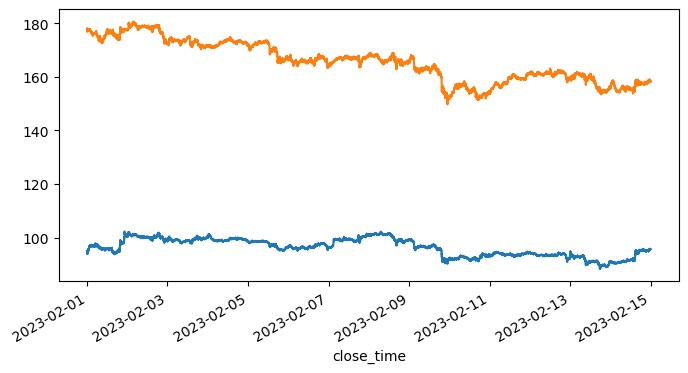

Проверка каждой пары на нестационарность
должно быть (False, False):  (False, False)
-----------------------------
Проверка на коинтеграцию
Хотя бы одно из должно быть True:
1:  True
2:  False
3:  True
-----------------------------
Параметры модели аппроксимации спреда, модель 1: [  1.84694969 -12.15158328]
-----------------------------
Параметры модели аппроксимации спреда, модель 2: [ 0.3459014  38.97710159]
-----------------------------
График спреда


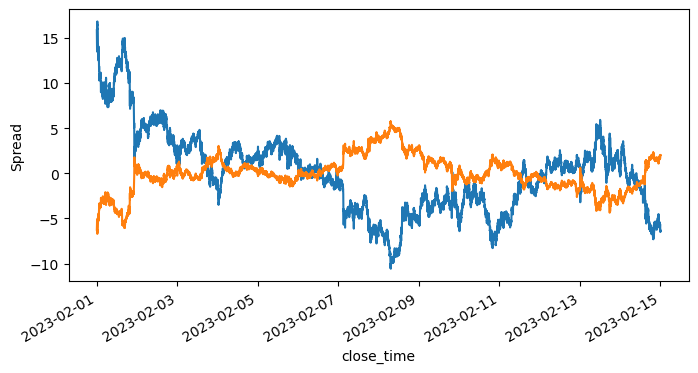

-----------------------------
График Z_score


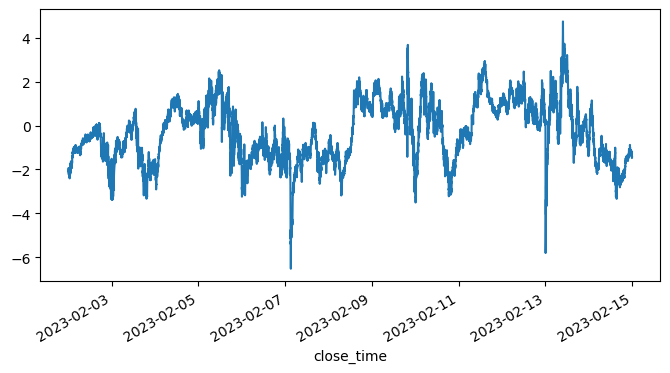

In [62]:
model = strategy(path_1,path_2, delta_t=0.6, output=True)

# Функция для теста (работы)

преобразует данные о цене двух активов в z_score, по которому выставляются ордера 

In [35]:
def work(model, N, path_1, path_2, output):
    
    # распаковываем коэффициенты 
    alpha = model[0]
    beta = model[1]
    
    data = data_preparing(path_1, path_2)
    
    # График цен закрытия пары активов
    if output:
        data.X.plot(figsize=(8,4))
        data.Y.plot(figsize=(8,4))
        plt.show()
    
    if output:

        # Проверка каждой пары на нестационарность
        print('Проверка каждой пары на нестационарность')
        print('должно быть (False, False): ', f'({is_stationary(data.X.tolist())}, {is_stationary(data.Y.tolist())})')
        
        print('-----------------------------')
    
        print('Проверка на коинтеграцию')
        print('Хотя бы одно из должно быть True:')
    
        # Проверка на коинтеграцию методом ЭГ
        print('1: ',engle_granger_test(data.X.tolist(), data.Y.tolist()))
    
        # Проверка на линейную коинтеграцию 
        print('2: ',kss_test(data.X.tolist(), data.Y.tolist(), lin=True))
        
        # Проверка на нелинейную коинтеграцию 
        print('3: ',kss_test(data.X.tolist(), data.Y.tolist(), lin=False))
    
        print('-----------------------------')
    
    #Заполняем спред и рисуем его 
    data['spread'] = data.Y - alpha*data.X - beta
    
    if output:    
        print('График спреда')
        data.spread.plot(figsize=(8,4))
        plt.ylabel("Spread")
        plt.show()
    
        print('-----------------------------')
    
    # Calculate rolling mean and standard deviation with window n
    ma = data.spread.rolling(window=int(N)).mean()
    std = data.spread.rolling(window=int(N)).std()
    
    # z_score
    if output:
        print('График Z_score')
    data['z'] = (data.spread - ma)/std
    if output:
        data.z.plot(figsize=(8,4))
    
    return data
    

# Функция индикатора ордеров

финальный индикатор, которые показывает, когда входить или выходить из позиции

In [36]:
def indicator(data, output):
    indicator = [0 for _ in range(len(data.z))]
    for i in range(0, len(data.z)):
        if math.isnan(data.z[i]):
            indicator[i] = 0
        # были вне позиции, открытие позиции в шорт
        if data.z[i] >= 2 and indicator[i-1] == 0:
            indicator[i] = -1
            
        # были в шорте, продолжаем сидеть в шорте 
        if indicator[i-1] == -1 and data.z[i] >= 0: # 0 -> 1
            indicator[i] = -1
        
        # были вне позиции, открытие позиции в лонг
        if data.z[i] <= -2 and indicator[i-1] == 0:
            indicator[i] = 1 
        # были в лонге, открытие позиции в лонг
        if indicator[i-1] == 1 and data.z[i] <= 0: # 0 -> -1
            indicator[i] = 1
        
        # закрытие шортовой позиции
        if data.z[i] <= 0 and indicator[i-1] == -1: # 0 -> 1
            indicator[i] = 0 
        
        # закрытие шортовой позиции
        if data.z[i] >=0 and indicator[i-1] == 1: #0 -> -1
            indicator[i] = 0 
    
    # позиции для спреда 
    data['spread_position'] = indicator
    
    # график
    if output:
        print('Позиции на графике спреда (торгуем спредом)')
        plt.figure(figsize=(25, 10))
        plt.scatter(data.index[data.spread_position == 0],data.z[data.spread_position == 0], color = 'blue', s=10)
        plt.scatter(data.index[data.spread_position == 1],data.z[data.spread_position == 1], color = 'green', s=10)
        plt.scatter(data.index[data.spread_position == -1],data.z[data.spread_position == -1], color = 'red', s=10)
        plt.show()
    
    position_asset_1 = [0 for _ in range(len(data.spread_position))]
    position_asset_2 = [0 for _ in range(len(data.spread_position))]
    
    for i in range(len(data.spread_position)):
        if data.spread_position[i] == 0:
            position_asset_1[i] = 0
            position_asset_2[i] = 0
        
        if data.spread_position[i] == -1:
            position_asset_1[i] = 1
            position_asset_2[i] = -1
        
        if data.spread_position[i] == 1:
            position_asset_1[i] = -1
            position_asset_2[i] = 1
        
    data['Asset_1_pos'] = position_asset_1
    data['Asset_2_pos'] = position_asset_2
    
    if output:
        print('Позиции на графиках пар (ТУТ ВОЗМОЖНО ОШИБКА И НАДО НАОБОРОТ)')

        plt.figure(figsize=(25, 10))
        plt.scatter(data.index[data.Asset_1_pos == 0],data.X[data.Asset_1_pos == 0], color = 'blue', s=10)
        plt.scatter(data.index[data.Asset_1_pos == 1],data.X[data.Asset_1_pos == 1], color = 'green', s=10)
        plt.scatter(data.index[data.Asset_1_pos == -1],data.X[data.Asset_1_pos == -1], color = 'red', s=10)

        plt.scatter(data.index[data.Asset_2_pos == 0],data.Y[data.Asset_2_pos == 0], color = 'blue', s=10)
        plt.scatter(data.index[data.Asset_2_pos == 1],data.Y[data.Asset_2_pos == 1], color = 'green', s=10)
        plt.scatter(data.index[data.Asset_2_pos == -1],data.Y[data.Asset_2_pos == -1], color = 'red', s=10)

    return data

# Запускаем train

он даёт параметры model, n - они нужны для работы основного блока

In [37]:
path_1 = "C:/Users/ahrus/Данные с прошлого компьютера/Руслан/Работа/SA/DATA/LTC/LTC.csv"
path_2 = "C:/Users/ahrus/Данные с прошлого компьютера/Руслан/Работа/SA/DATA/XMR/XMR.csv"

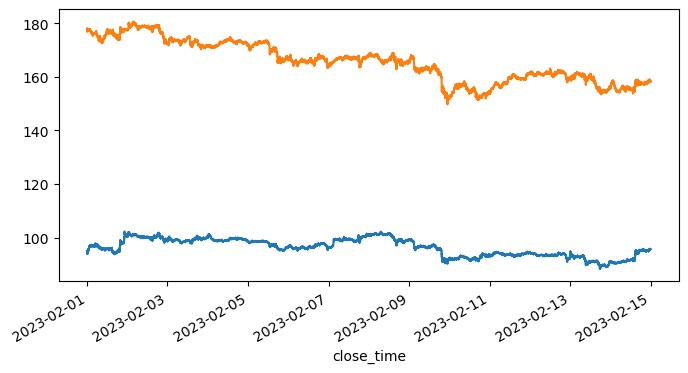

Проверка каждой пары на нестационарность
должно быть (False, False):  (False, False)
-----------------------------
Проверка на коинтеграцию
Хотя бы одно из должно быть True:
1:  True
2:  False
3:  True
-----------------------------
Параметры модели аппроксимации спреда: [  1.84694969 -12.15158328]
-----------------------------
График спреда


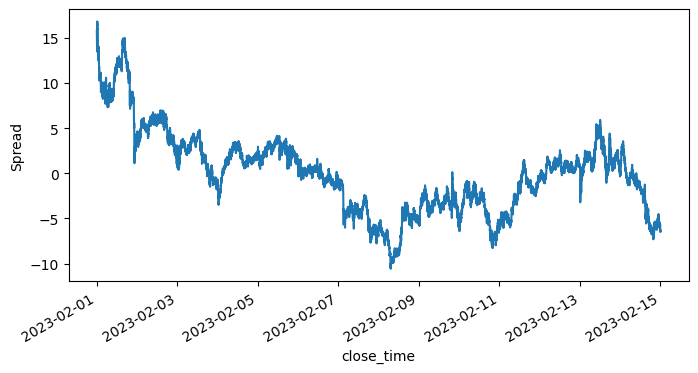

-----------------------------
График Z_score


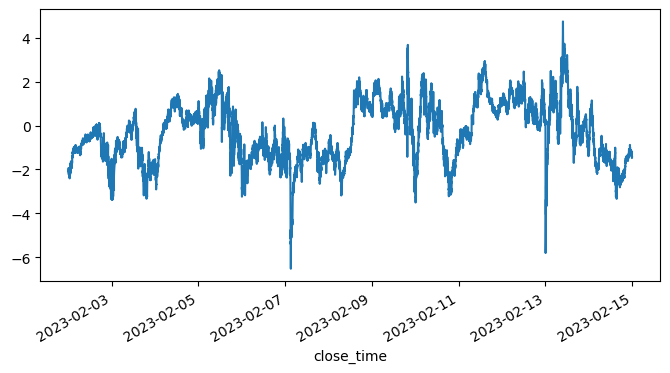

In [38]:
model, n = strategy(path_1,path_2, delta_t=0.6, output=True)

# Запускаем стратегию на тестовых (или текущих данных)

даёт нам финальную матрицу, из которой надо извлечь два последних столбца

In [39]:
path_1 = "C:/Users/ahrus/Данные с прошлого компьютера/Руслан/Работа/SA/DATA/LTC/LTC.csv"
path_2 = "C:/Users/ahrus/Данные с прошлого компьютера/Руслан/Работа/SA/DATA/XMR/XMR.csv"

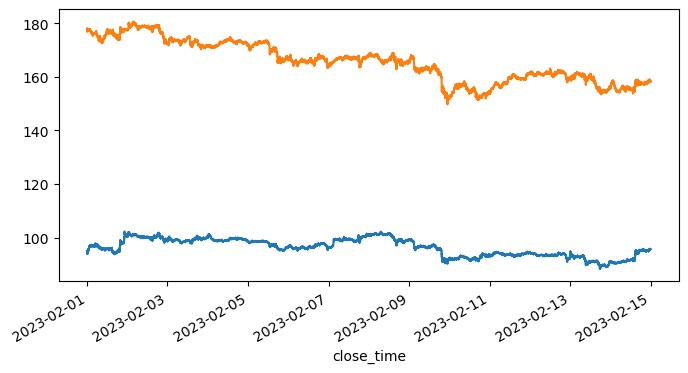

Проверка каждой пары на нестационарность
должно быть (False, False):  (False, False)
-----------------------------
Проверка на коинтеграцию
Хотя бы одно из должно быть True:
1:  True
2:  False
3:  True
-----------------------------
График спреда


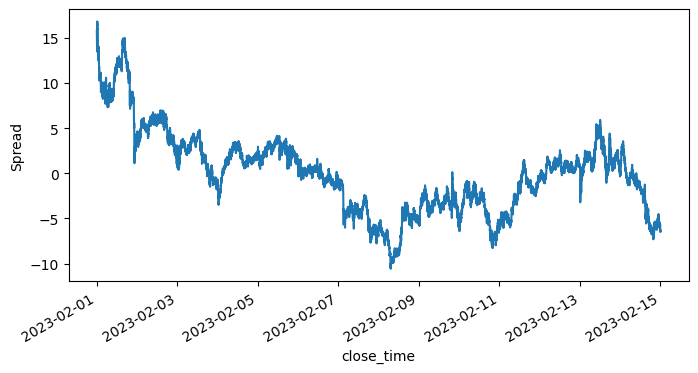

-----------------------------
График Z_score


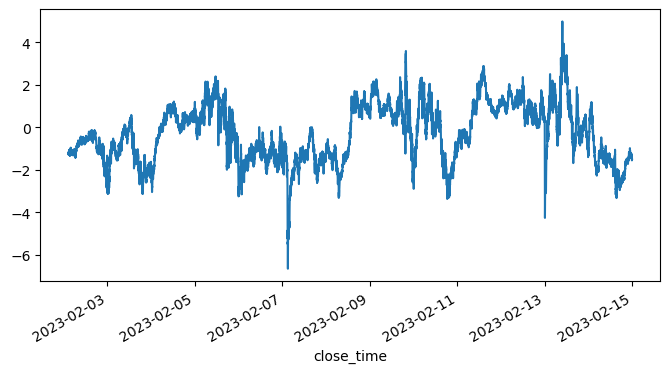

In [22]:
data_current = work(model, n, path_1,path_2, True) 

In [23]:
# data_current

In [ ]:
data_current = indicator(data_current, True)

# Финальный результат - два после

In [ ]:
data_current